In [1]:
import tensorflow as tf
import numpy as np # math computations
import matplotlib.pyplot as plt # Plotting bar chart
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.layers import Layer, Resizing, Rescaling
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomContrast
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp

In [2]:
# Get dataset and information from the Tensorflow datasets
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised = True, shuffle_files = True, split=['train'])

In [3]:
# Check out the dataset and the info
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

# Data Preparation

In [4]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO): 
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
    test_dataset = val_test_dataset.skip(int(TEST_RATIO * DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset

In [5]:
# Partition 
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = split(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# Dataset Visualization

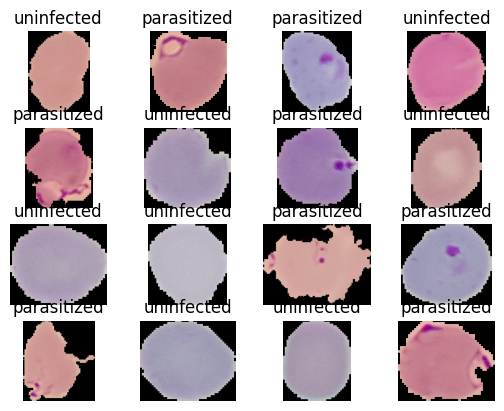

In [6]:
# Visualization 
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

In [7]:
dataset_info.features['label'].int2str(1) # Encode the labels.

'uninfected'

# Data Preprocessing

In [8]:
# Data Augmentation

In [9]:
def visualize(original, augmented):
    plt.subplot(1,2,1)
    plt.imshow(original)
    plt.subplot(1,2,2)
    plt.imshow(augmented)

In [10]:
original_image, label = next(iter(train_dataset))

In [11]:
augmented_image = tf.image.adjust_saturation(original_image, saturation_factor= 0.3)

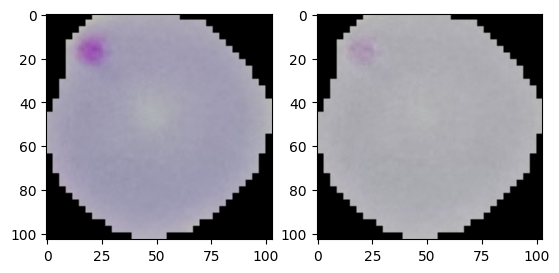

In [12]:
visualize(original_image, augmented_image)

In [13]:
IMAGE_SIZE = 224

In [14]:
def resizing_rescale(image, label):
    return tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0, label

In [15]:
train_dataset = train_dataset.map(resizing_rescale)
val_dataset = val_dataset.map(resizing_rescale)
test_dataset = test_dataset.map(resizing_rescale)
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [16]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [17]:
BATCH_SIZE = 32
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [18]:
lenet_model = tf.keras.Sequential([
                            InputLayer(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)),
                            
                            Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2, strides=2),
                            
                            Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2, strides=2),
                            
                            Flatten(),
                            
                            Dense(100, activation="relu"),
                            BatchNormalization(),
                            Dense(10, activation="relu"),
                            BatchNormalization(),
                            Dense(1, activation="sigmoid"),
                                                      
])
lenet_model.summary()

c:\Users\antho\Python_ws\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

In [23]:
lenet_model.compile(optimizer=Adam(learning_rate=0.1),
            loss = BinaryCrossentropy(),
            metrics = ['accuracy']) 

In [24]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=25, verbose=1)

Epoch 1/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 84s 119ms/step - accuracy: 0.9115 - loss: 0.2744 - val_accuracy: 0.9212 - val_loss: 0.2997
Epoch 2/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 79s 115ms/step - accuracy: 0.9282 - loss: 0.2382 - val_accuracy: 0.9332 - val_loss: 0.2320
Epoch 3/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 78s 113ms/step - accuracy: 0.9374 - loss: 0.2014 - val_accuracy: 0.9249 - val_loss: 0.2576
Epoch 4/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 79s 114ms/step - accuracy: 0.9395 - loss: 0.1873 - val_accuracy: 0.5318 - val_loss: 1.2024
Epoch 5/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 81s 118ms/step - accuracy: 0.9459 - loss: 0.1737 - val_accuracy: 0.9430 - val_loss: 0.2089
Epoch 6/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 82s 119ms/step - accuracy: 0.9507 - loss: 0.1565 - val_accuracy: 0.9445 - val_loss: 0.1852
Epoch 7/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 80s 116ms/step - accuracy: 0.9477 - loss: 0.1579 - val_accuracy: 0.7546 - val_loss: 0.4763
Epoch 8/25
689/689 ━━━━━━━━━━━━━━━━━━━━ 79s 115ms/step - accuracy: 0.9529 - loss: 0

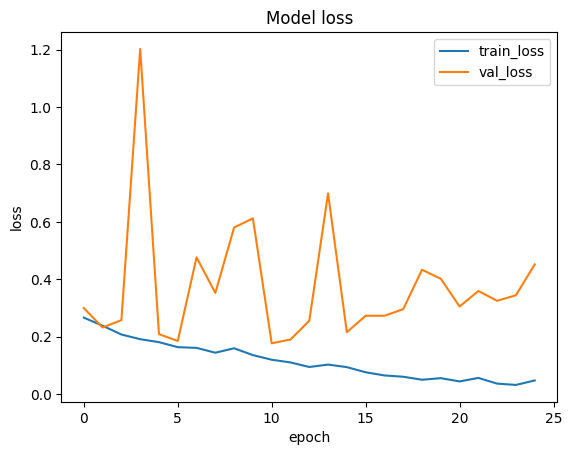

In [25]:
# Visualization 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

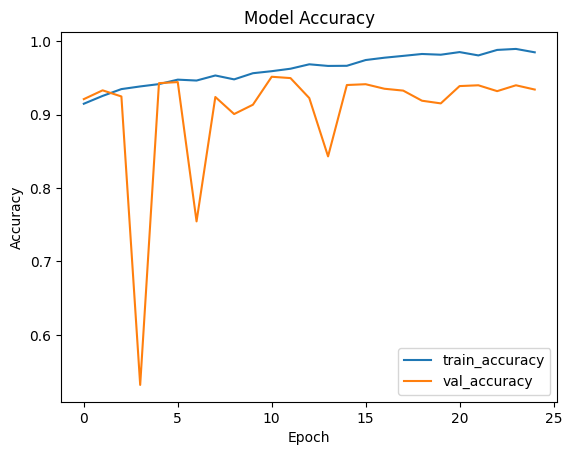

In [26]:
# Visualization
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()